In [2]:
import numpy as np

import sys
sys.path.insert(0, '..') 
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM, load_random_exp_povm
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import clustering as cl
from EMQST_lib.qrem import QREM
from joblib import Parallel, delayed
import pickle 
import glob
import time
import uuid
import scipy.cluster.hierarchy as sch
from EMQST_lib import support_functions as sf
from joblib import Parallel, delayed
plt.rcParams.update({'font.size': 15})
np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2

# QREM on 16 qubits with structure, using (realistic exp. data)

[[2], [11], [0, 1], [8, 9, 10], [14], [6, 7], [3], [15], [4, 5], [12, 13]]
dict_keys(['no_QREM', 'factorized_QREM', 'two_RDM_QREM', 'classical_correlated_QREM', 'correlated_QREM', 'Z', 'noise_cluster_labels', 'two_point_corr_labels', 'rho_true_array', 'traced_down_rho_true_array', 'initial_cluster_size', 'noise_mode', 'n_QDT_shots', 'n_QST_shots_total', 'n_cores', 'n_qubits', 'n_averages', 'state_size_array', 'result_name_list', 'comparison_modes', 'dendrogram_cutoff', 'cluster_QDOT'])
['No QREM ', 'Factorized QREM', 'Two-point QREM', 'Classical correlated QREM', 'Correlated QREM']
['No QREM ', 'Factorized QREM', 'Two-point QREM', 'Classical correlated QREM', 'Correlated QREM']
['No QREM ', 'Factorized QREM', 'Two-point QREM', 'Classical correlated QREM', 'Correlated QREM']
['No QREM ', 'Factorized QREM', 'Two-point QREM', 'Classical correlated QREM', 'Correlated QREM']
['No QREM ', 'Factorized QREM', 'Two-point QREM', 'Classical correlated QREM', 'Correlated QREM']
['No QREM ', 'Facto

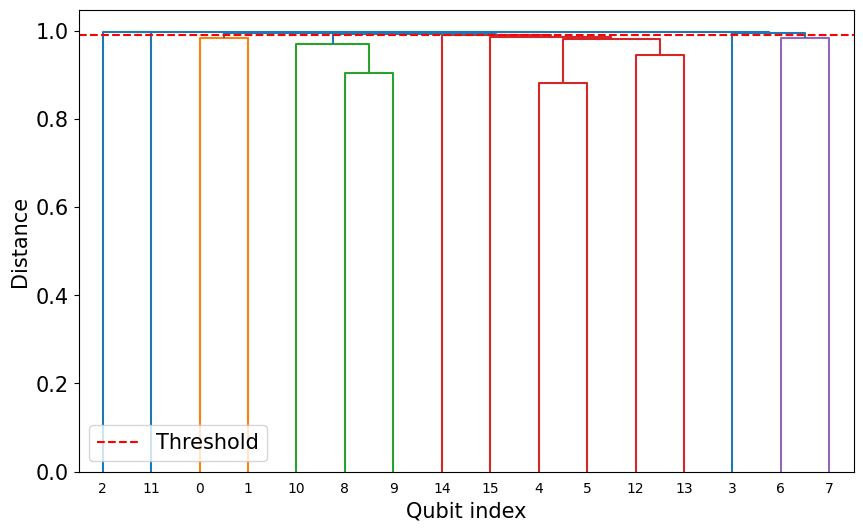

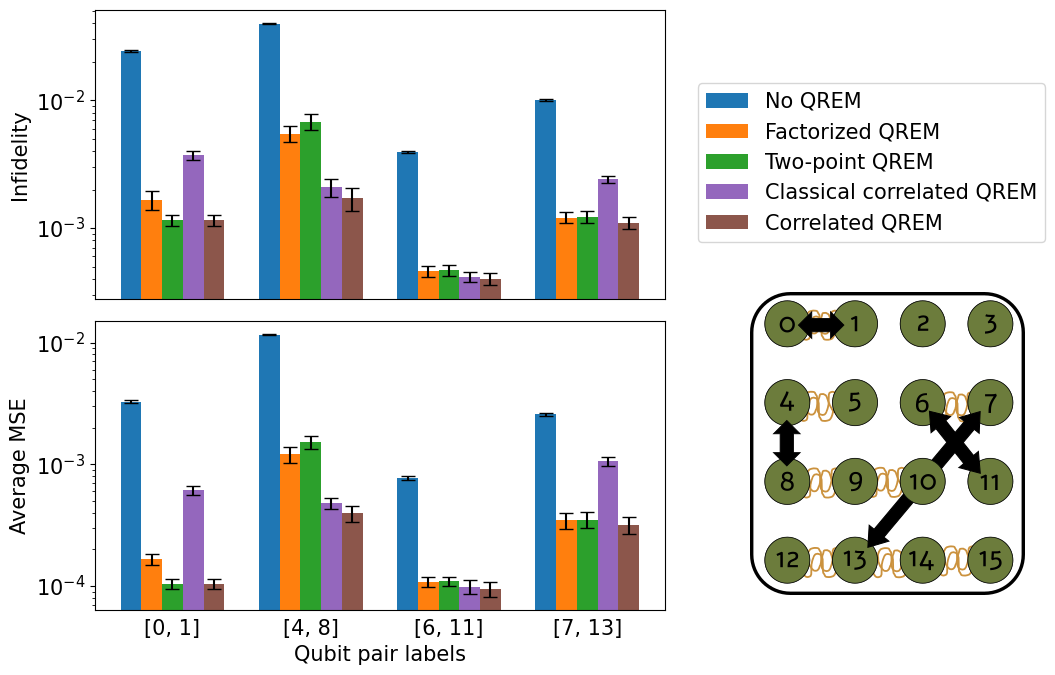

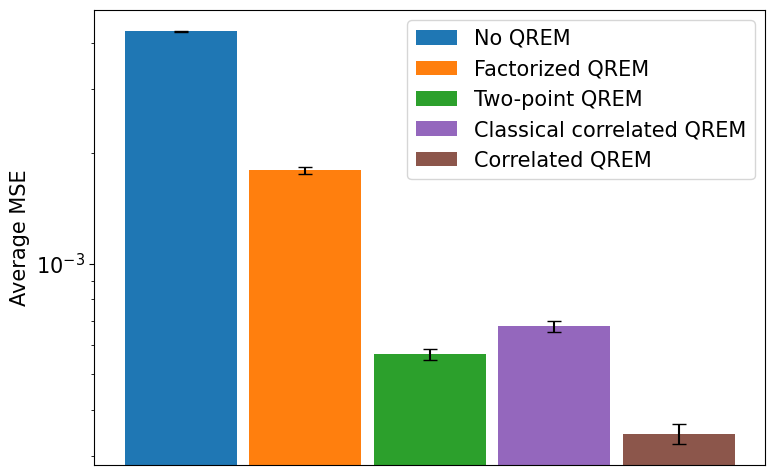

In [44]:
# Plotting
#data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"
#filter_array = np.array([0,1,2,4,5])
perm_data_path = "QDOT_results/16_exp_example/100k_QST_shots"

# For loading of 
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))

Z = dict_array[0]['Z']
cutoff = dict_array[0]['dendrogram_cutoff']
vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff)
noise_labels = dict_array[0]['noise_cluster_labels']
print(noise_labels)
print(dict_array[0].keys())
n_averages = dict_array[0]['n_averages']
two_point_corr_labels   = dict_array[0]['two_point_corr_labels']
traced_down_rho_true_array = dict_array[0]['traced_down_rho_true_array']


# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)
true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]

inf_array = []
state_array = []
MSE_array = []
for dict in dict_array:
    state, label_array = ot.load_state_array_from_result_dict(dict)
    print(label_array)
    #perfect_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict)
    # The states has shapes [n_modes, n_averages, len(two_point_corr_labels), 2**n_qubits, 2**n_qubits]
    inf_array.append(ot.compute_mode_mean_infidelitites(state, traced_down_rho_true_array))#[filter_array]
    state_array.append(state)
    exp_value = ot.compute_state_array_exp_values(state,op_string_array)
    MSE_array.append(ot.compute_op_and_n_averages_mean_MSE(exp_value, true_exp_value))
    # Resulting arrays have shapes [std_averages,n_modes,n_correlators]

# Average over the std_deviation runs
mean_inf_array = np.mean(inf_array, axis=0)
mean_MSE_array = np.mean(MSE_array, axis=0)



fig, ax = plt.subplots(2,1)
if len(two_point_corr_labels) > 4:
    x = np.arange(4)  # How many correlators to plot
else:
    x = np.arange(len(two_point_corr_labels))
width = 0.15  # the width of the bars
multiplier = 0
corr_label_index = [0,1,2,3]
#perfect_inf_array = ot.compute_mode_mean_infidelitites(standard_state_array, traced_down_rho_true_array)
print(mean_inf_array.shape)
color=['C0', 'C1','C2','C4','C5']
for i in range(len(label_array)):
    offset = width * multiplier
    
    rects = ax[0].bar(x + offset,mean_inf_array[i,corr_label_index], width, label=label_array[i], color = color[i])
    ax[0].errorbar(x + offset, mean_inf_array[i,corr_label_index], yerr=np.std(inf_array, axis=0)[i,corr_label_index], fmt='none', ecolor='k', capsize=5)
        #ax[0].plot(x + offset, perfect_inf_array[i,:,:4], "kx", label="Exact POVMs" if multiplier == 0 else "")
    
     
        #ax[0].plot(x + offset, perfect_inf_array[i], "kx", label="Exact POVMs" if multiplier == 0 else "")        
    multiplier += 1
ax[0].set_yscale('log')
if len(two_point_corr_labels) > 4:
    ax[0].set_xticks(x + 2.3*width, two_point_corr_labels[:4])
else:
    ax[0].set_xticks(x + 2.3*width, two_point_corr_labels)
ax[0].set_ylabel('Infidelity')



    
if len(two_point_corr_labels) > 4:
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels[corr_label_index]]
else:
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]

multiplier = 0

for i in range(len(label_array)):
    offset = width * multiplier
    
    rects = ax[1].bar(x + offset, mean_MSE_array[i,corr_label_index], width, color = color[i])
    ax[1].errorbar(x + offset, mean_MSE_array[i,corr_label_index], yerr=np.std(MSE_array, axis=0)[i,corr_label_index], fmt='none', ecolor='k', capsize=5)
        #ax[1].plot(x + offset, perfect_clustering_MSE[i,:4], "kx")

    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx")
    multiplier += 1
    
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')
ax[-1].set_xticks(x + 2*width, corr_x_label)
ax[-1].set_xlabel('Qubit pair labels')
img = plt.imread("images/Cluster_formation_16_qubit_example.png")
fig.figimage(img, 750, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(1,0.75))
fig.savefig(f'images/Results/Correlator_spesific_MSE_16_example.png')
handels, labels = ax[0].get_legend_handles_labels()





fig_main, ax_main = plt.subplots(1,1)

mean_over_correlators = np.mean(mean_MSE_array, axis=1)
std_mean_over_correlators = np.mean(MSE_array,axis = 2)
#perfect_mean_MSE = np.mean(perfect_clustering_MSE, axis=1)
bars = ax_main.bar(label_array, mean_over_correlators, width*6, color=['C0', 'C1','C2','C4','C5'])
ax_main.errorbar(label_array, mean_over_correlators, yerr=np.std(std_mean_over_correlators, axis=0), fmt='none', ecolor='k', capsize=5)
#ax_main.plot(label_array, perfect_mean_MSE, "kx")
#ax_main.set_title('Average MSE over random correlators')
ax_main.set_ylabel('Average MSE')
ax_main.set_yscale('log')
ax_main.legend(handels, labels)
ax_main.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
fig_main.set_size_inches(8, 5)
fig_main.tight_layout()
fig_main.savefig(f'images/Results/main_result_16_example.png', dpi = 300)
#fig_main.legend(loc='center left', bbox_to_anchor=(1,0.75))



# ISWAP noise

[array([[0.011, 0.033, 0.067, 0.085],
       [0.006, 0.031, 0.128, 0.22 ],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.086],
       [0.006, 0.031, 0.129, 0.22 ],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.085],
       [0.006, 0.031, 0.129, 0.22 ],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.085],
       [0.006, 0.031, 0.128, 0.219],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.085],
       [0.006, 0.031, 0.129, 0.218],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.086],
       [0.006, 0.031, 0.129, 0.22 ],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.085],
       [0.006, 0.031, 0.129, 0.217],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.086],
       [0.006, 0.031, 0.128, 0.22 ],
       [0.   , 0.003, 0.001, 0.001]]), array([[0.011, 0.033, 0.067, 0.086],
       [0.006, 0.031, 0.128, 0.22 ],
       [0.001, 0.003,

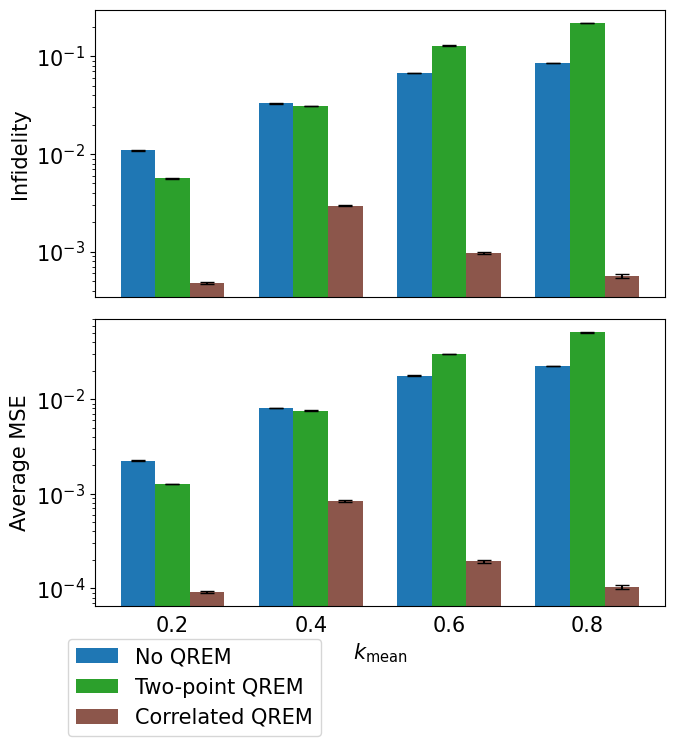

In [45]:
perm_data_path = "QDOT_results/iswap_example/2025-02-28_14-12-35_94de5dd2-bca1-4162-aecd-9d609f982429"

# For loading of 
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))

# with open(f'{perm_data_path}/result_QST.npy', 'rb') as f:
#     dict_array = np.load(f, allow_pickle=True)
# dict_array has shape [n_std_deviation, n_k_mean]
#perfect_clustering_dict_array = dict_array[1]

# # Compute infidelities:
# The matrix has the shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
# traced_down_rho_true_array has the shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]

def k_mean_infidelity_computation(state_matrix, rho_true_array):
    """
    Computes the inifdelities to be plotted for the k-mean plot
    state_matrix comes in shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
    rho_true_array comes in shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]

    will return infidelities averaged over n_averages and n_two_point_corr, final shape will be [n_k_mean, n_modes]
    """
    mode_mean_inf = [ot.compute_mode_mean_infidelitites(k_mean,rho_true_array) for k_mean in state_matrix]
    # Returns a list of arrays of shape [n_k_mean, n_modes, len(two_point_corr_labels)]
    return np.mean(mode_mean_inf, axis = 2)


def compute_k_mean_expectation_values(state_matrix,op_string_array):
    """
    Computes expectation values for a given state matrix.
    state_matrix shape has [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
    returns expectation values of shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels), n_op]
    """
    return np.array([ot.compute_state_array_exp_values(matrix,op_string_array) for matrix in state_matrix])

def compute_k_mean_mean_MSE(exp_value_array, true_exp_value):
    """
    Computes the mean MSE for a given expectation value array
    true_exp_value is of shape [n_averages, len(two_point_corr_labels), n_op]
    exp_value_array is of shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels), n_op]
    returns an array of shape [n_k_mean, n_modes]
    """
    return np.array([[np.mean((true_exp_value - mode)**2) for mode in k_mean] for k_mean in exp_value_array])
# traced_down_rho_true_array = []
# for qrem_k_mean_array in qrem_array:
#     traced_down_rho_true_array.append(qrem_k_mean_array[0].traced_down_correlator_rho_true_array)


k_mean_array = [0.2, 0.4, 0.6, 0.8]


traced_down_rho_true_array = dict_array[0][0]['traced_down_rho_true_array']
n_averages = dict_array[0][0]['n_averages']
two_point_corr_labels   = dict_array[0][0]['two_point_corr_labels']

# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)
true_exp_value = compute_k_mean_expectation_values([[traced_down_rho_true_array]],op_string_array)[0]

# We need to treat each k-mean on it's own.
state_matrix = []
inf_matrix = []
inf = []
MSE = []
#perfect_clustering_state_matrix = []
for std_it in range(len(dict_array)):
    k_state_matrix = []
    for k_it in range(len(dict_array[std_it])):
        state_array, label_array = ot.load_state_array_from_result_dict(dict_array[std_it][k_it])
        #perfect_clustering_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict_array[k_it])
        k_state_matrix.append(state_array)
        
        #perfect_clustering_state_matrix.append(perfect_clustering_state_array)
    state_matrix.append(k_state_matrix)
    inf_k_mean= k_mean_infidelity_computation(k_state_matrix, traced_down_rho_true_array).T # T is to swap order of modes and k_mean
    inf.append(inf_k_mean)
    exp_value = compute_k_mean_expectation_values(k_state_matrix,op_string_array)
    MSE_k_mean = compute_k_mean_mean_MSE(exp_value, true_exp_value).T # Transpose to make method be outer layer
    MSE.append(MSE_k_mean)


inf_mean = np.mean(inf, axis = 0)
MSE_mean = np.mean(MSE, axis = 0)

#inf_average_perfect_clustering = k_mean_infidelity_computation(perfect_clustering_state_matrix, traced_down_rho_true_array).T
# Has the shape [n_standard_div,n_recon_modes, n_k_mean]
print(inf)
x = np.arange(len(k_mean_array))  # the k-mean label locations
color_array = ['C0', 'C2', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

for i in range(len(label_array)): 
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_mean[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    ax[0].errorbar(x + offset, inf_mean[i], yerr=np.std(inf, axis=0)[i], fmt='none', ecolor='k', capsize=5)
    #ax[0].plot(x + offset, inf_average_perfect_clustering[i], "kx", label="Perfect clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, k_mean_array)
ax[0].set_ylabel('Infidelity')




#perfect_clustering_exp_value_array = compute_k_mean_expectation_values(perfect_clustering_state_matrix,op_string_array)
#perfect_clustering_MSE = compute_k_mean_mean_MSE(perfect_clustering_exp_value_array, true_exp_value ).T

#print(standard_mean_MSE.shape)
multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, MSE_mean[i], width, color = color_array[i])
    ax[1].errorbar(x + offset, MSE_mean[i], yerr=np.std(MSE, axis=0)[i], fmt='none', ecolor='k', capsize=5)
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')


ax[-1].set_xticks(x + 1*width, k_mean_array)

ax[-1].set_xticks(x + 1*width, k_mean_array)
ax[-1].set_xlabel(r'$k_{\text{mean}}$')

#img = plt.imread("images/cluster_formation_16_iSWAP.png")
#fig.figimage(img, 680, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom = True) # labels along the bottom edge are off


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.1,0))#(0.15,0.5))
fig.savefig(f'images/Results/iSWAP_example.png',bbox_inches='tight', dpi = 300)



c:\Users\adrian\OneDrive\Skrivebord\PhD\Code\REMQST\EMQST_lib\visualization.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=plot_shape)


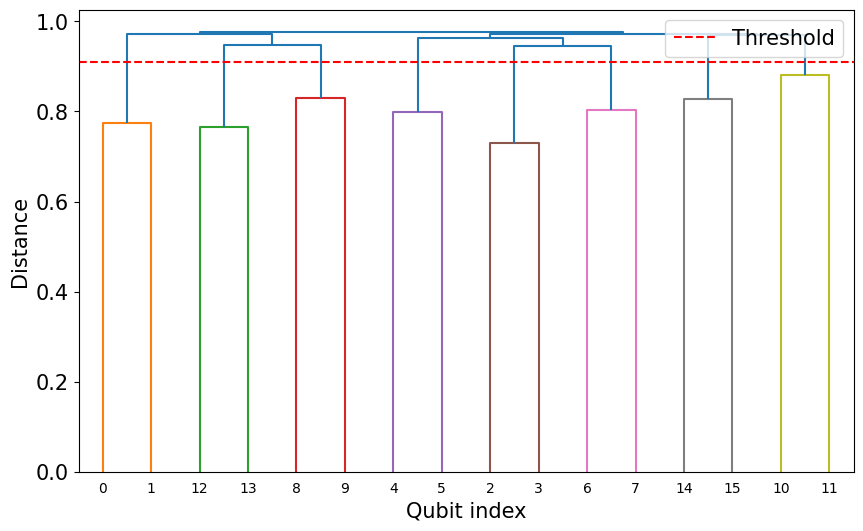

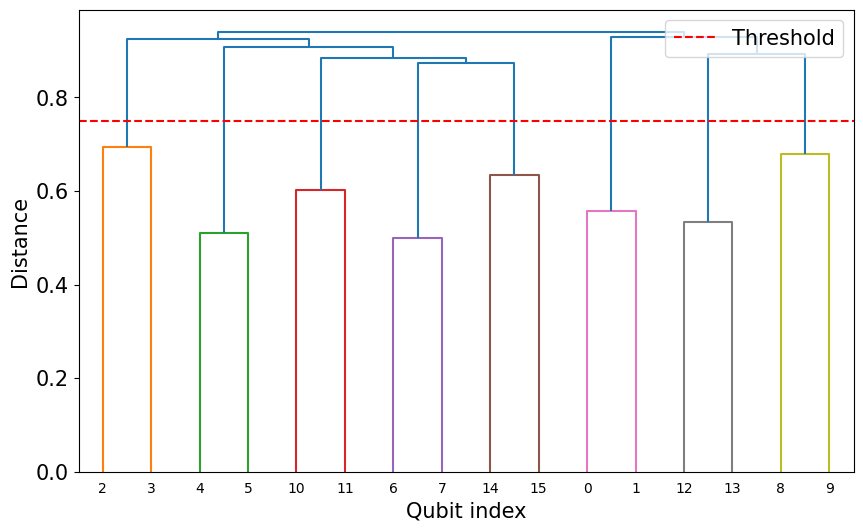

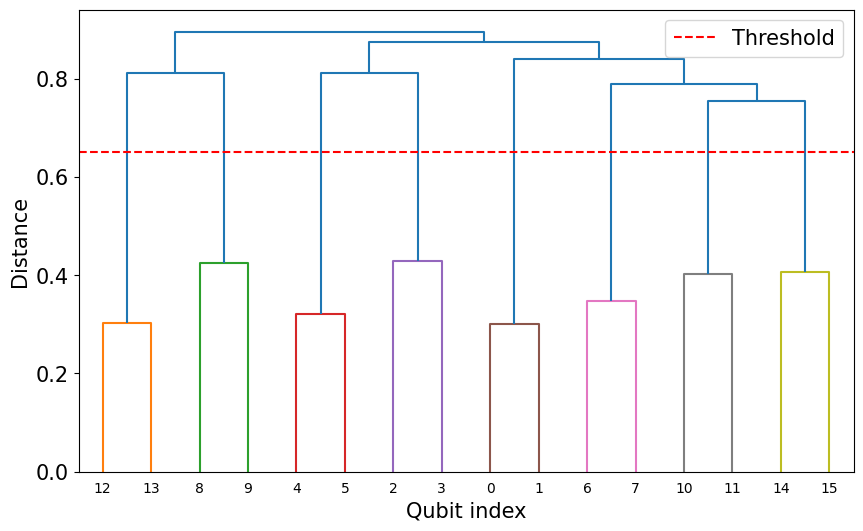

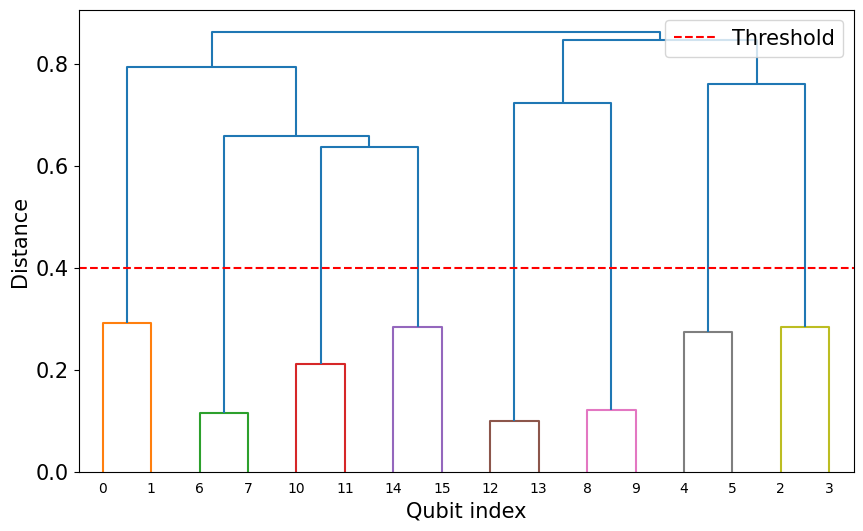

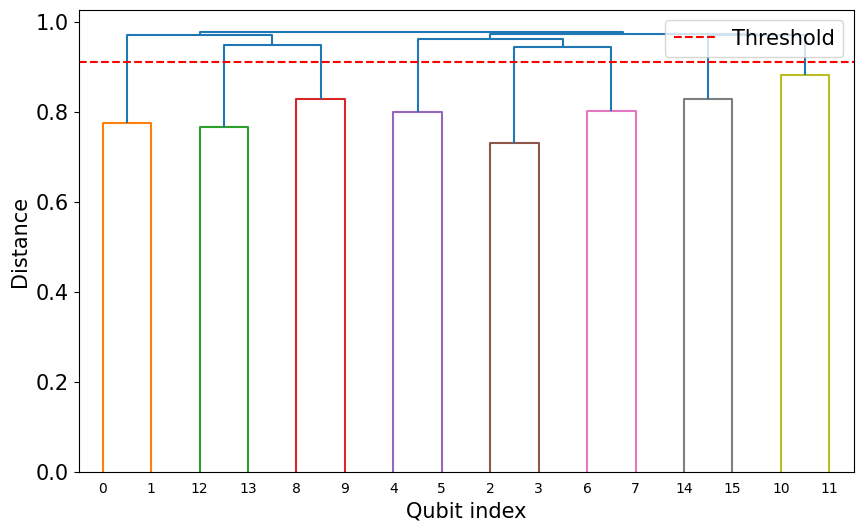

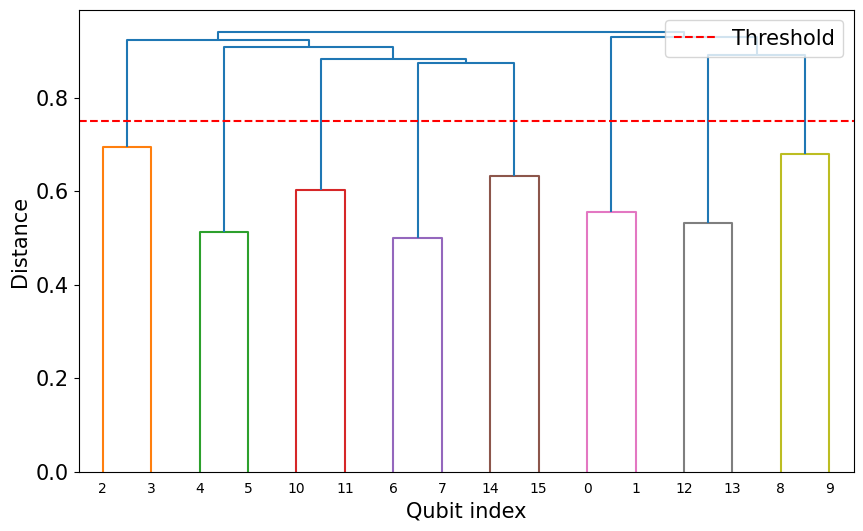

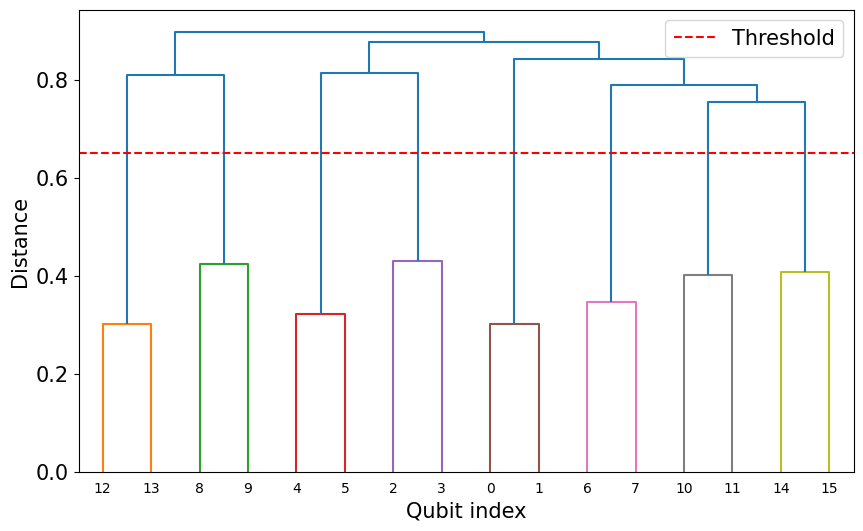

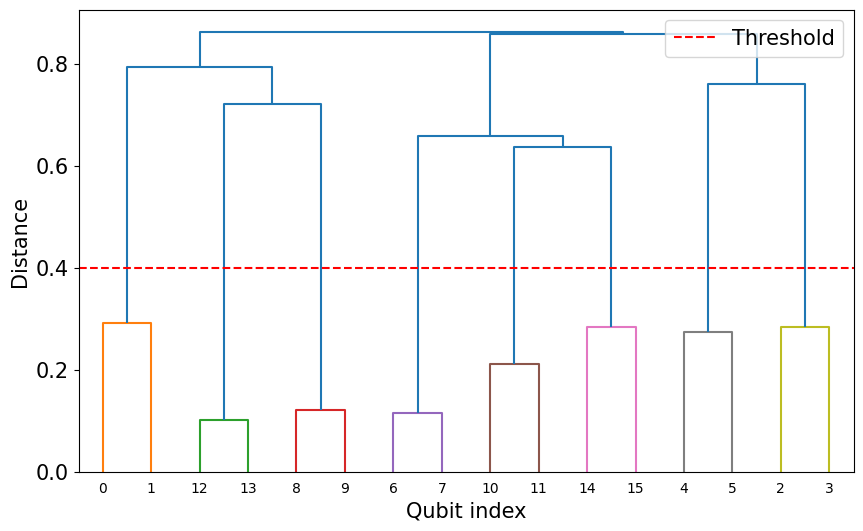

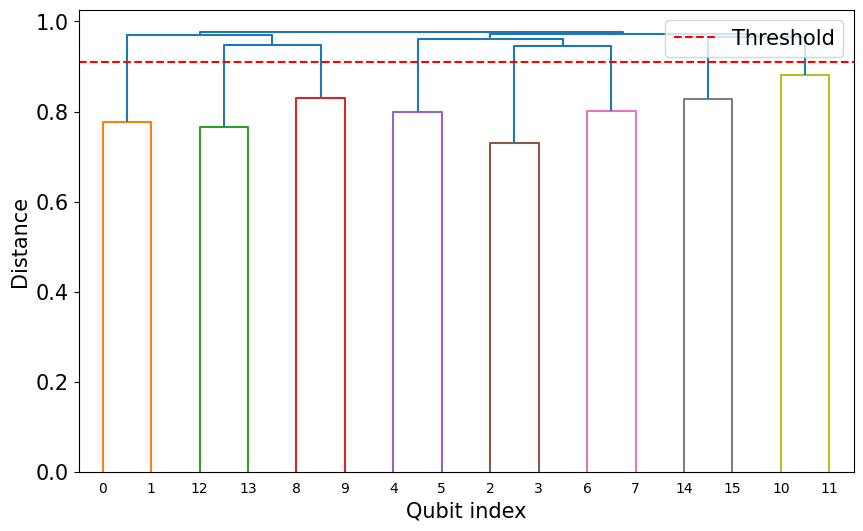

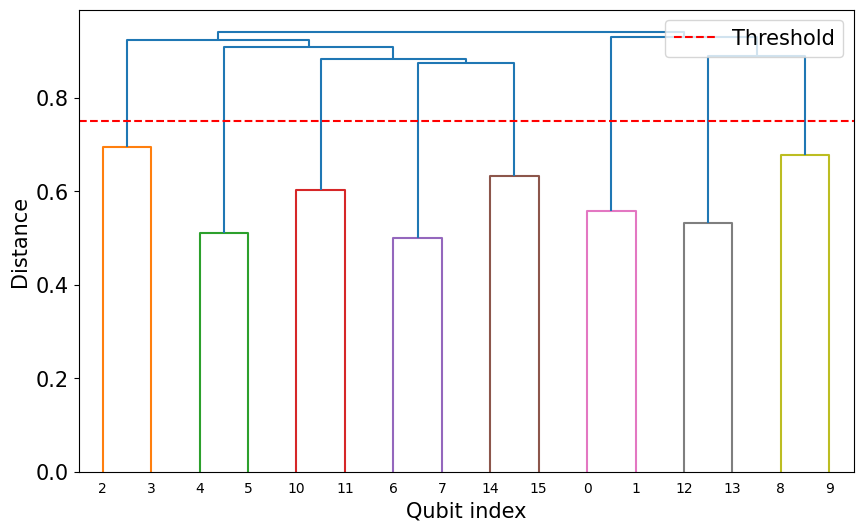

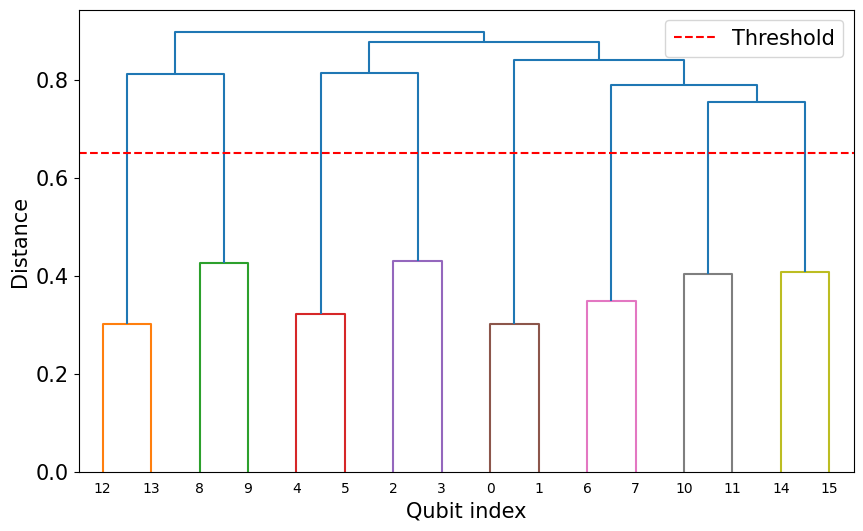

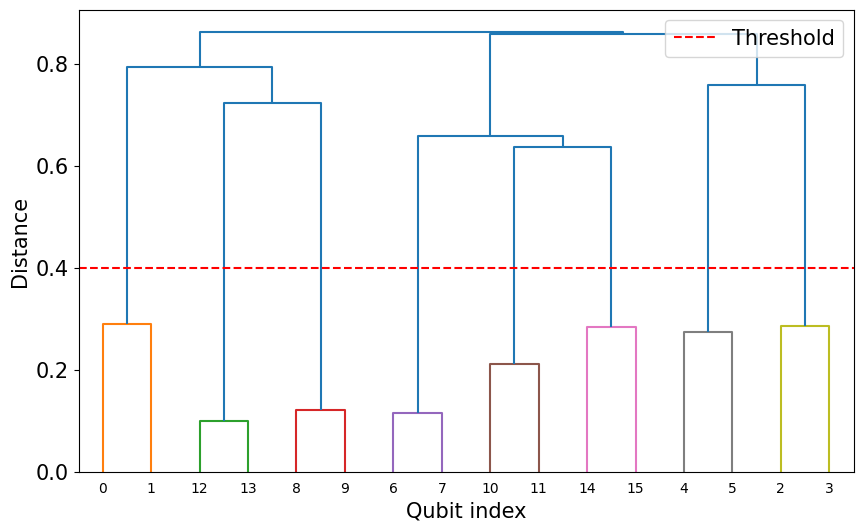

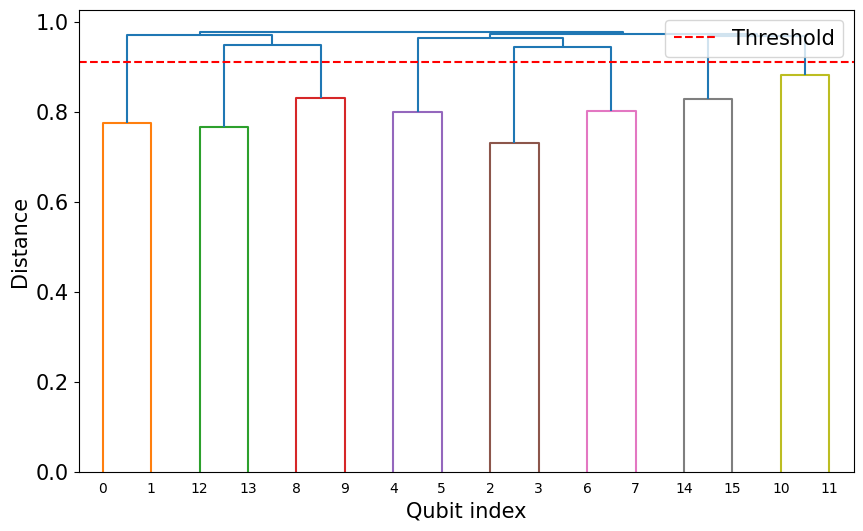

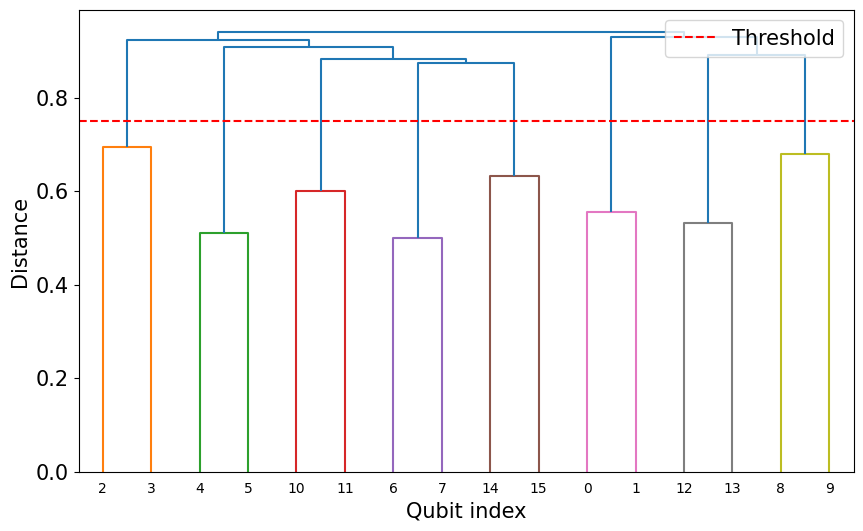

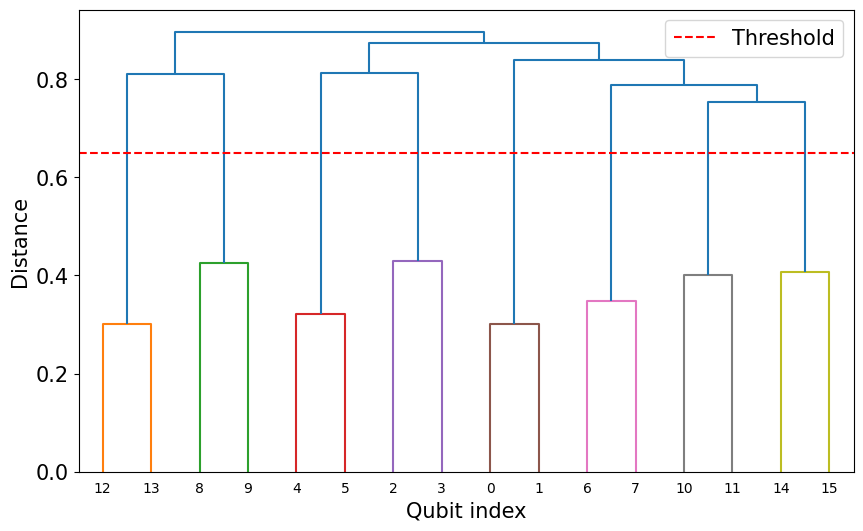

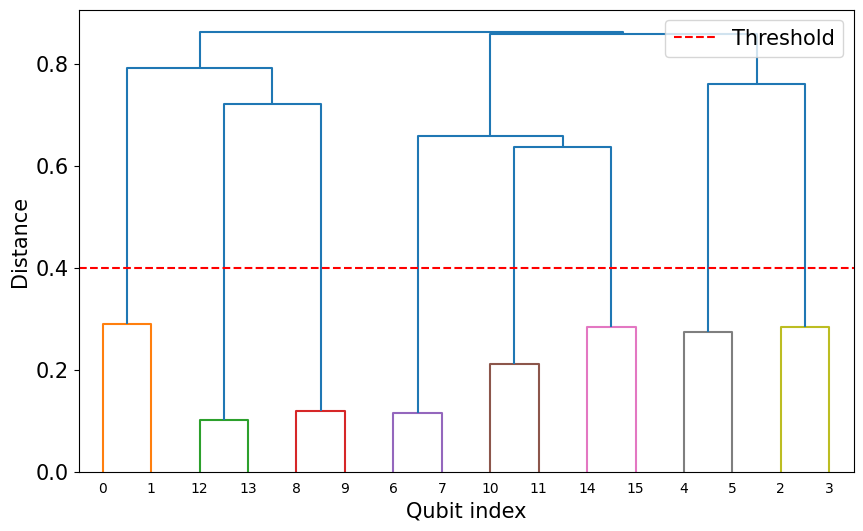

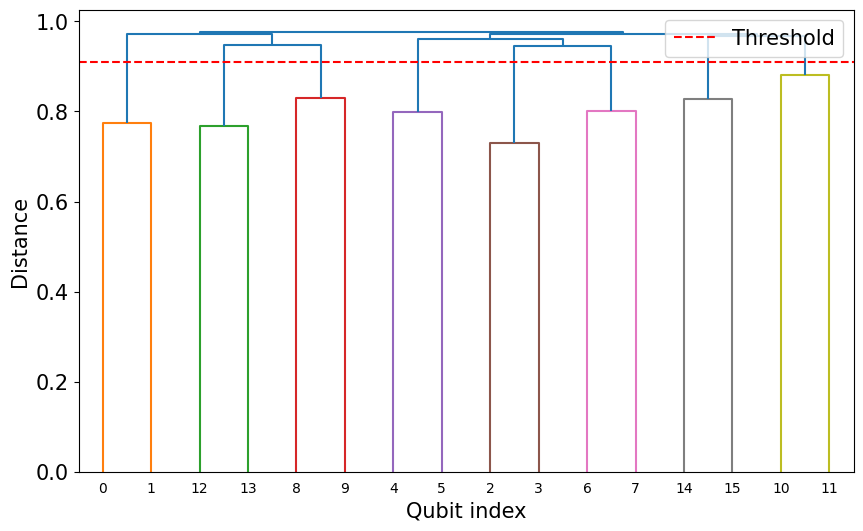

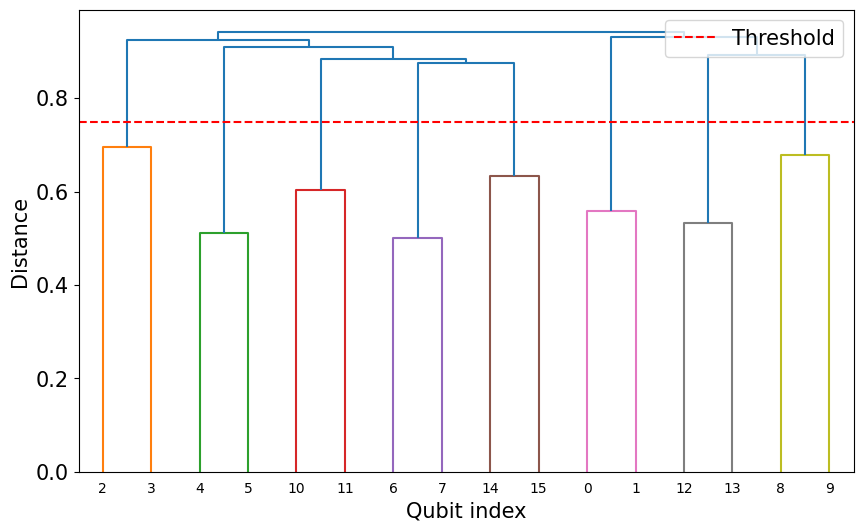

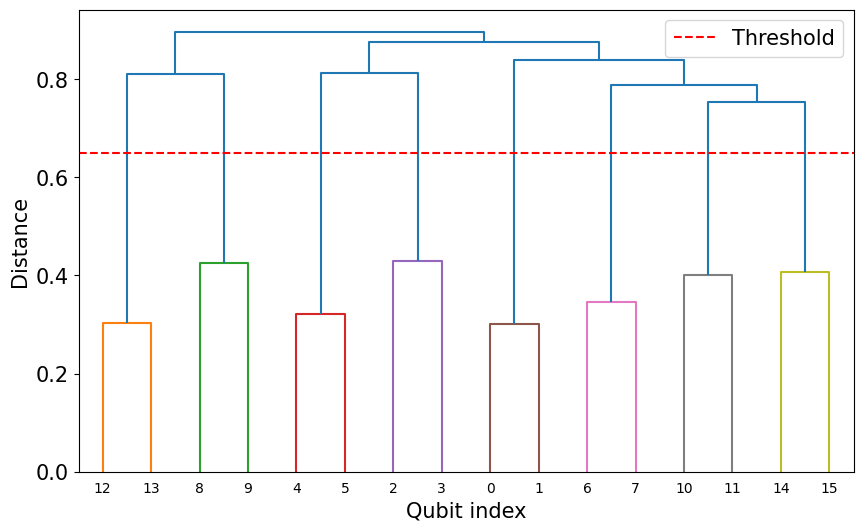

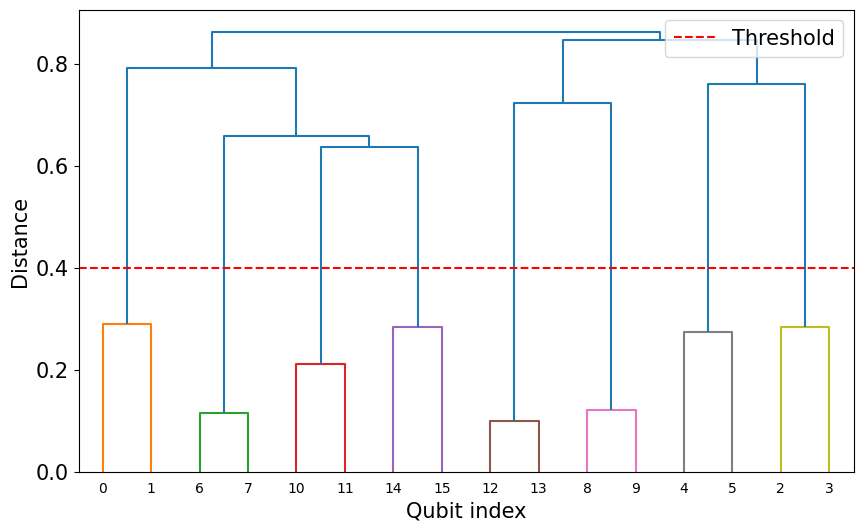

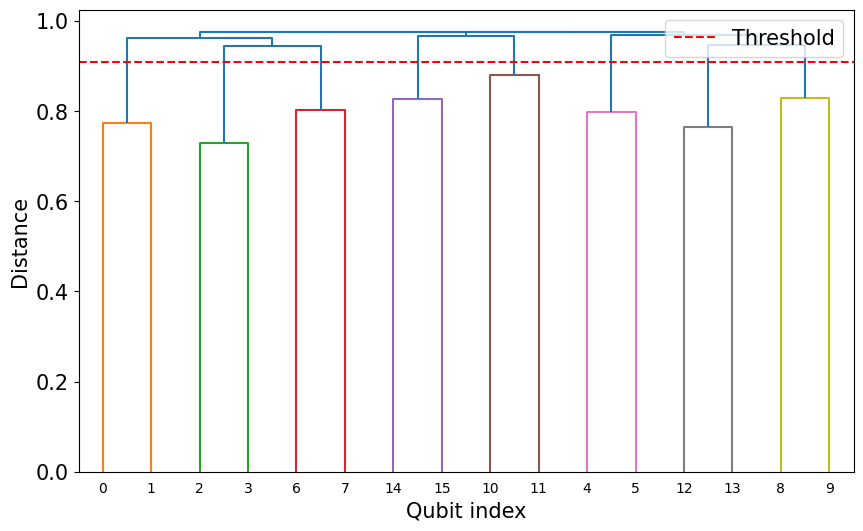

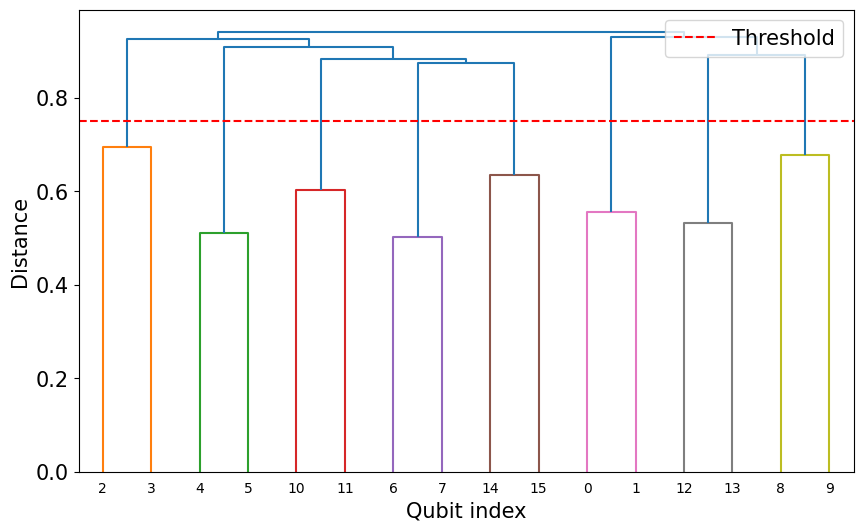

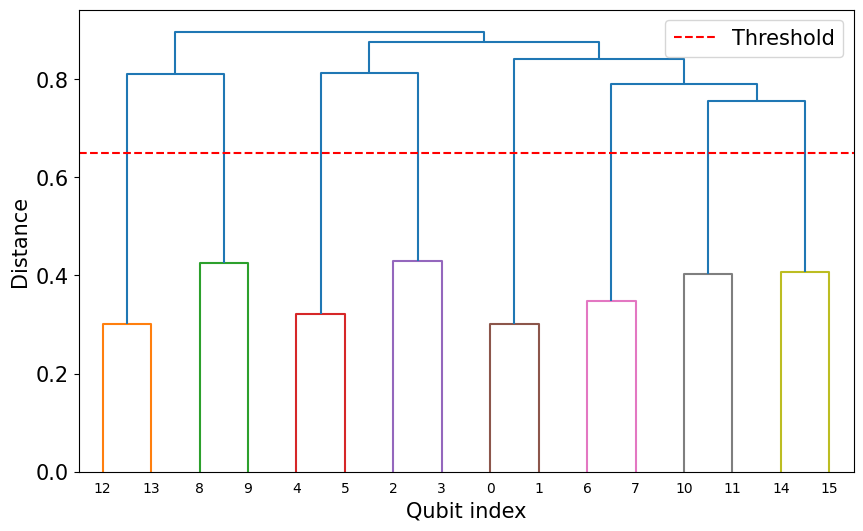

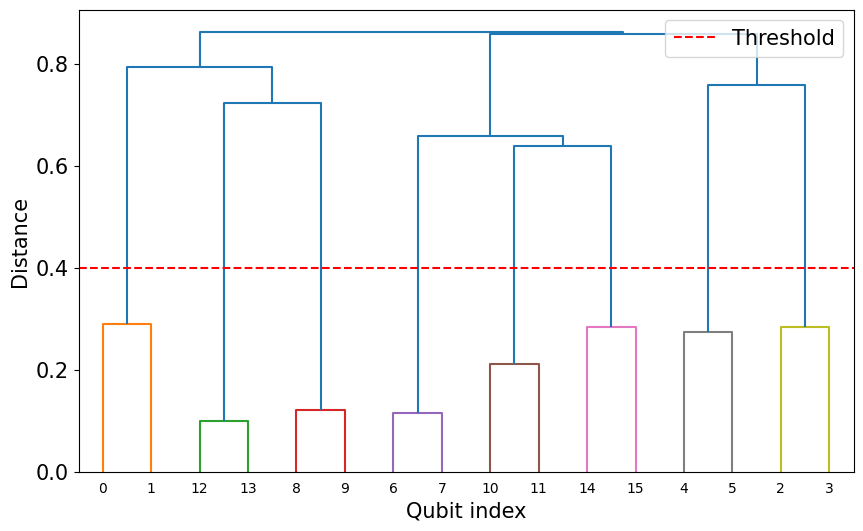

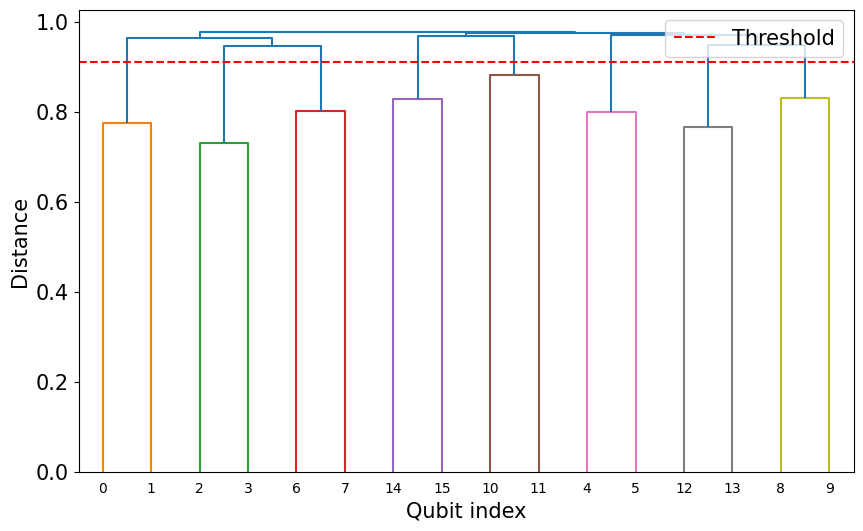

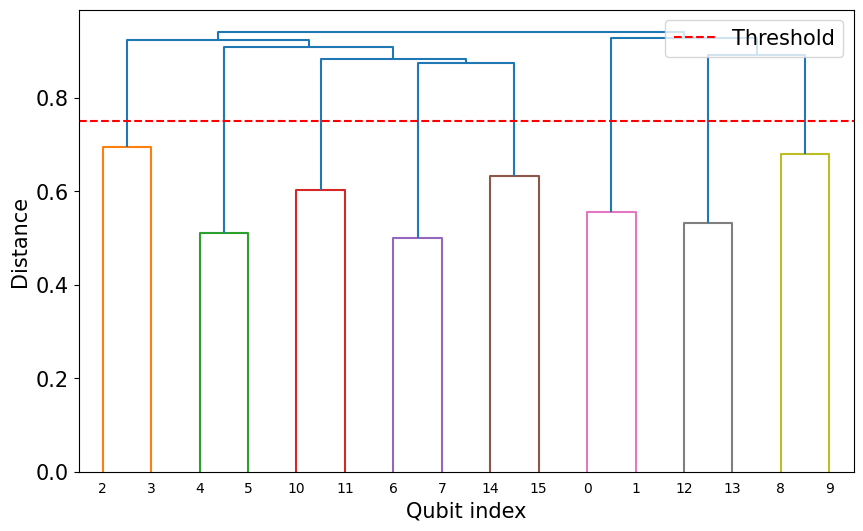

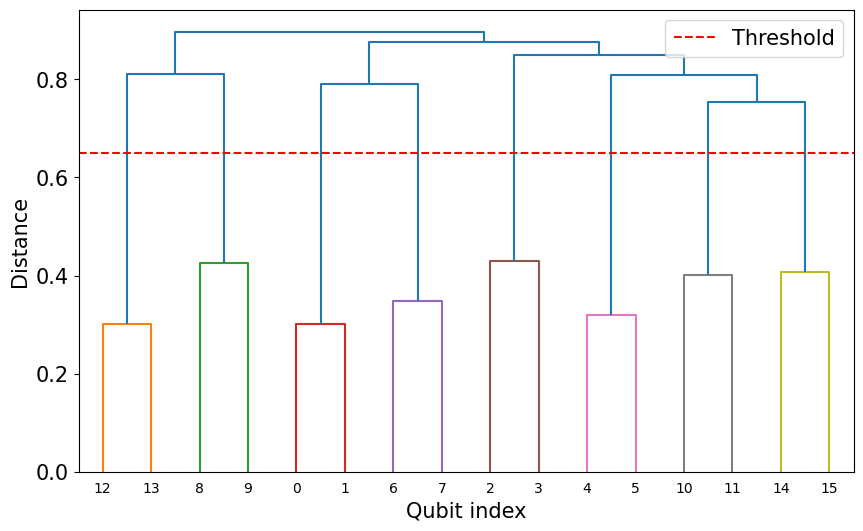

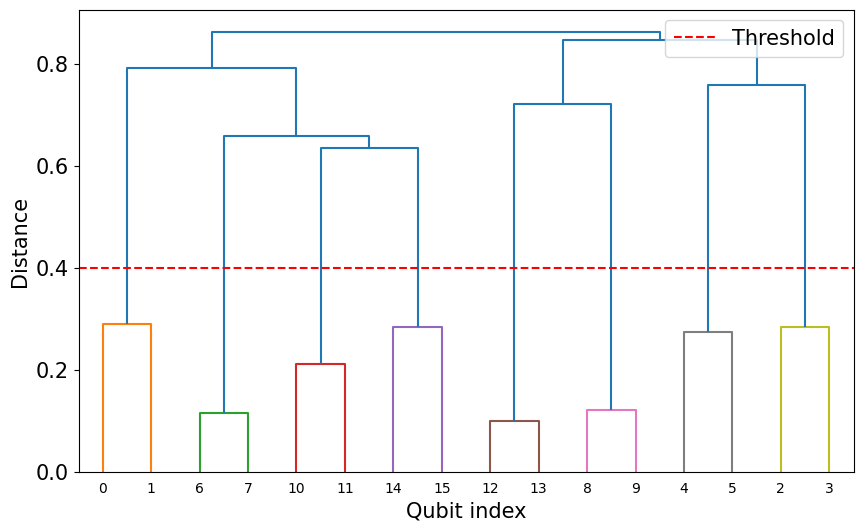

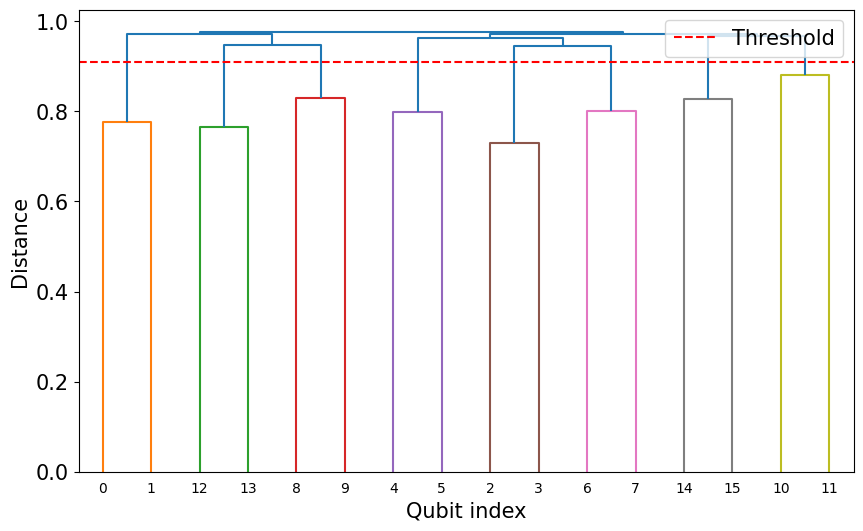

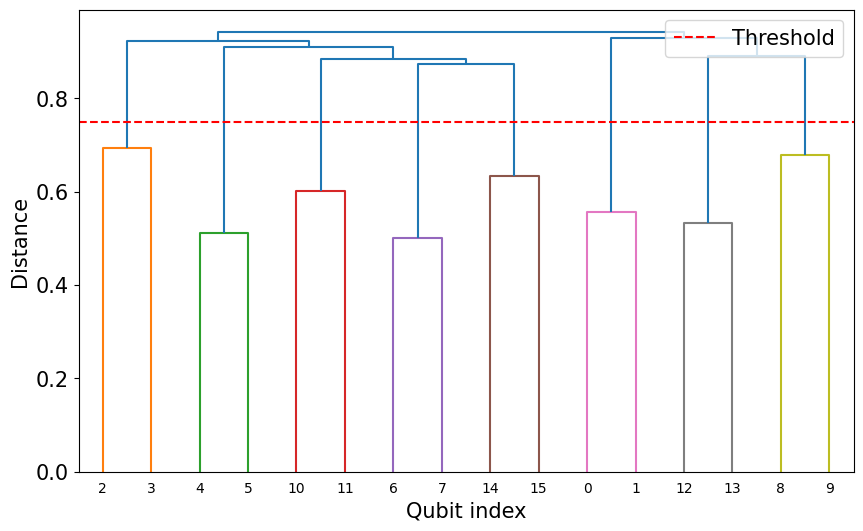

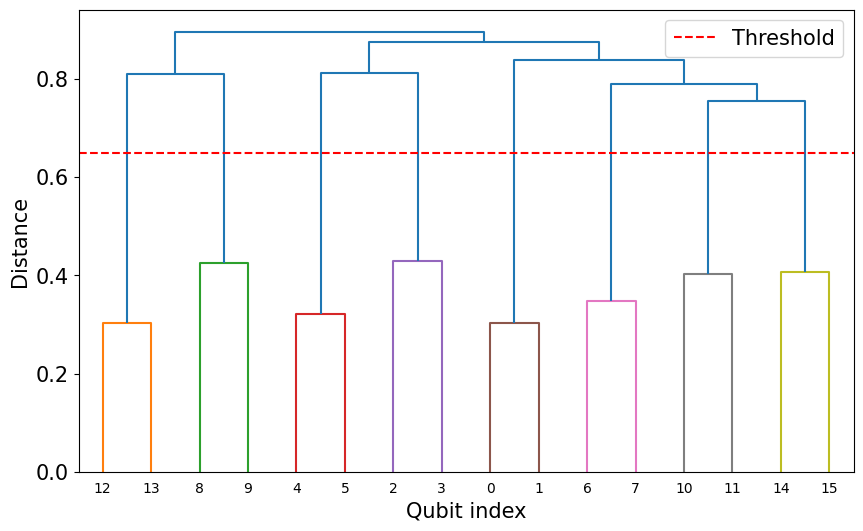

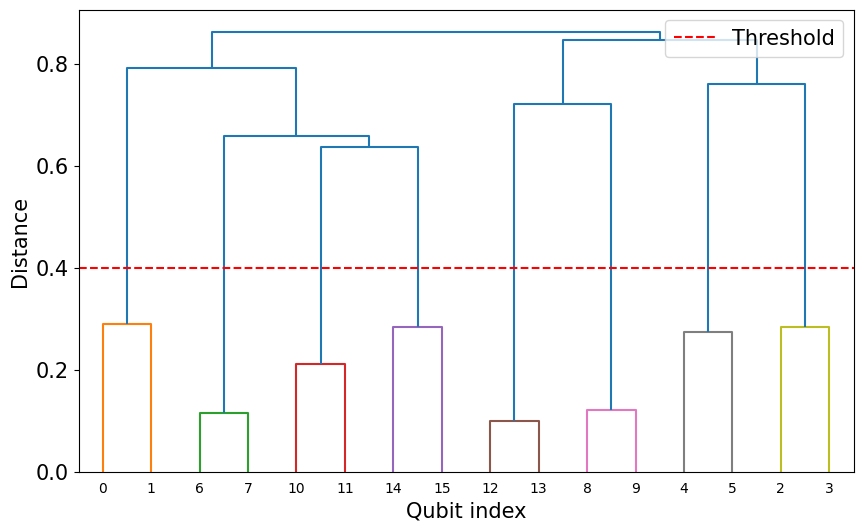

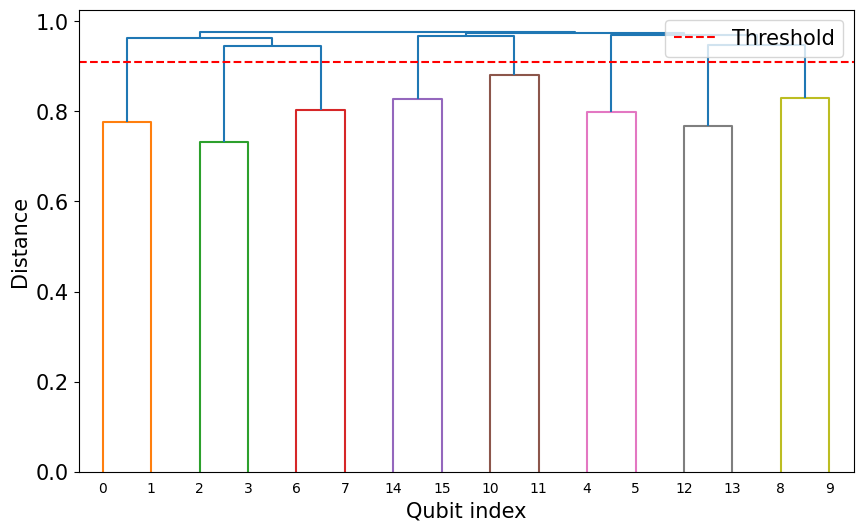

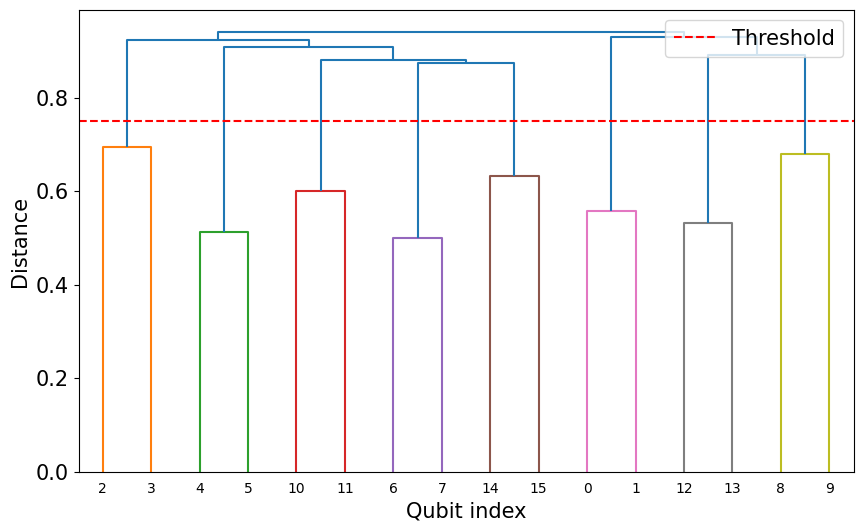

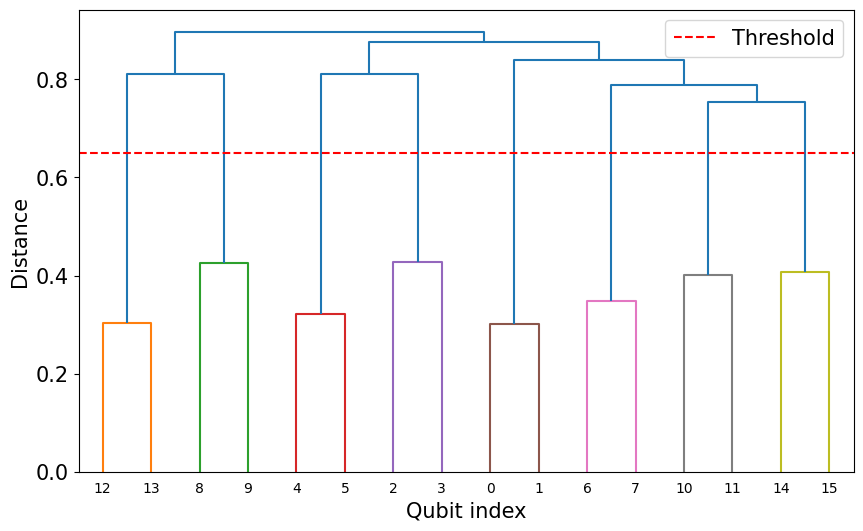

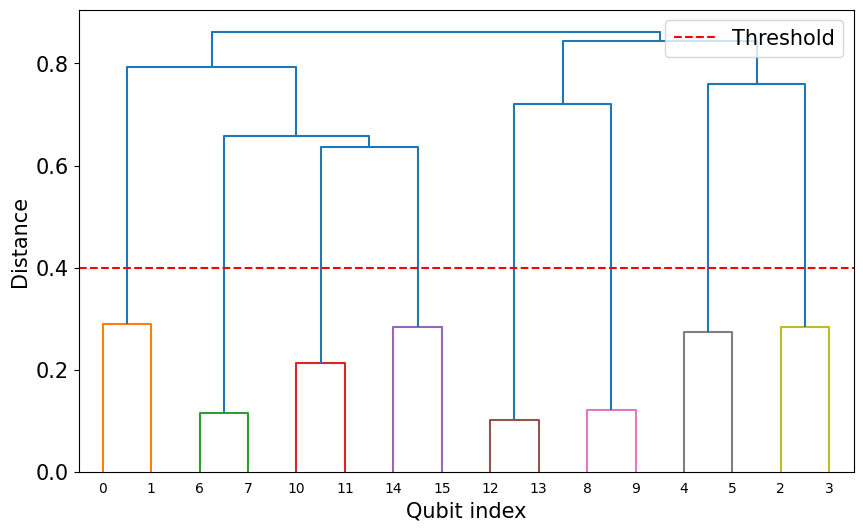

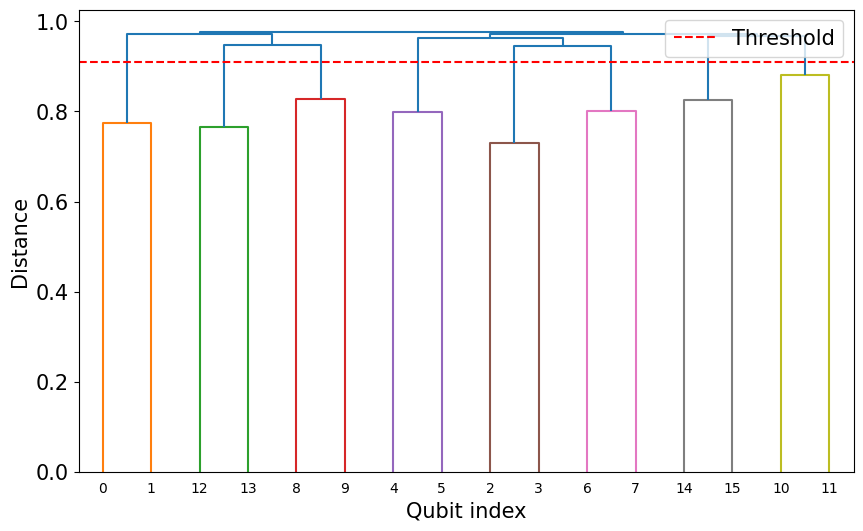

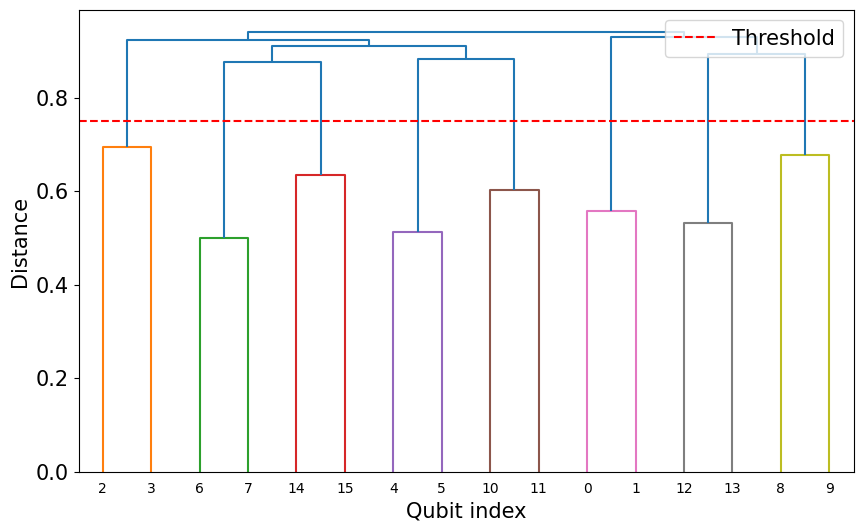

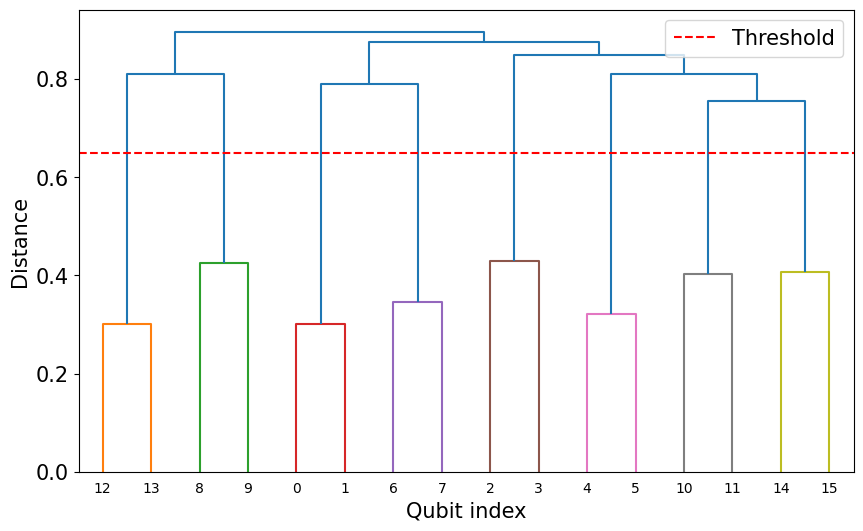

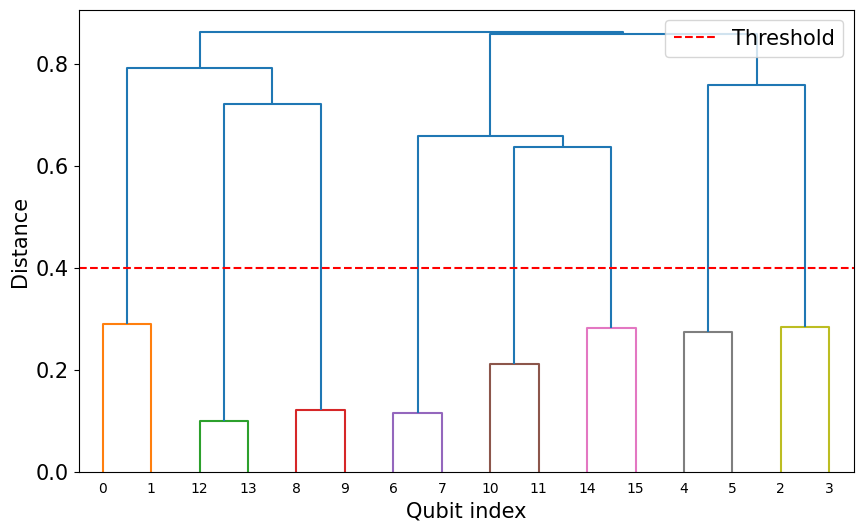

In [46]:
# Plotting dendrograms
update_cutoffs = [ 0.91, 0.75, 0.65, 0.4]
for dict in dict_array:
    for k_dict, cutoff in zip(dict, update_cutoffs):
        Z = k_dict['Z']
        #cutoff = k_dict['dendrogram_cutoff']
        vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff)
        #k_dict['noise_cluster_labels'] = cl.compute_noise_cluster_labels(k_dict['Z'], k_dict['dendrogram_cutoff'])

# Coherent noise

dict_keys(['no_QREM', 'factorized_QREM', 'two_RDM_QREM', 'classical_correlated_QREM', 'correlated_QREM', 'Z', 'noise_cluster_labels', 'two_point_corr_labels', 'rho_true_array', 'traced_down_rho_true_array', 'initial_cluster_size', 'noise_mode', 'n_QDT_shots', 'n_QST_shots_total', 'n_cores', 'n_qubits', 'n_averages', 'state_size_array', 'result_name_list', 'comparison_modes', 'dendrogram_cutoff', 'cluster_QDOT'])


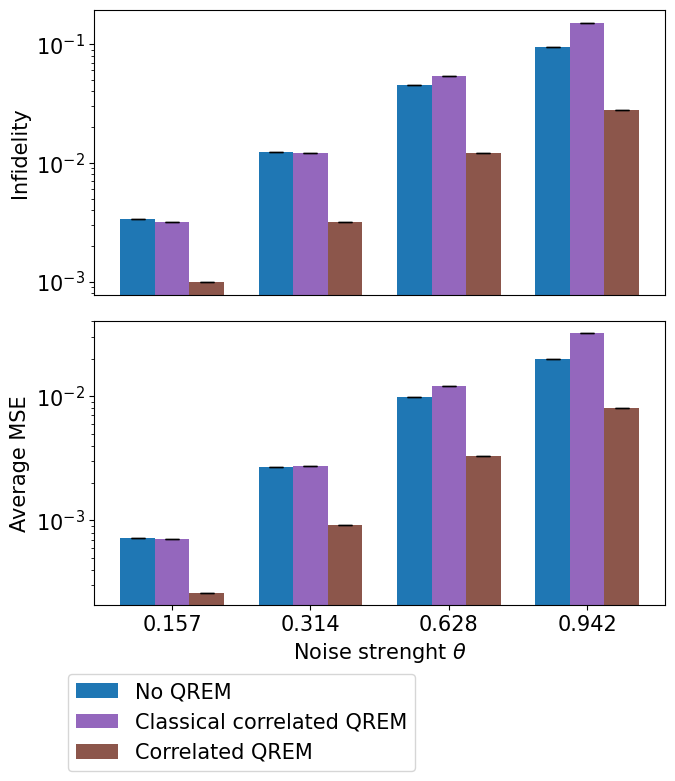

In [67]:
perm_data_path = "QDOT_results/coherent_example/ward"
rot_angle_array = np.array([5,10,20,30])* np.pi/100
np.set_printoptions(precision=3)
file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))
print(dict_array[0][0].keys())
def k_mean_infidelity_computation(state_matrix, rho_true_array):
    """
    Computes the inifdelities to be plotted for the k-mean plot
    state_matrix comes in shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
    rho_true_array comes in shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]

    will return infidelities averaged over n_averages and n_two_point_corr, final shape will be [n_k_mean, n_modes]
    """
    mode_mean_inf = [ot.compute_mode_mean_infidelitites(k_mean,rho_true_array) for k_mean in state_matrix]
    # Returns a list of arrays of shape [n_k_mean, n_modes, len(two_point_corr_labels)]
    return np.mean(mode_mean_inf, axis = 2)


def compute_k_mean_expectation_values(state_matrix,op_string_array):
    """
    Computes expectation values for a given state matrix.
    state_matrix shape has [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
    returns expectation values of shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels), n_op]
    """
    return np.array([ot.compute_state_array_exp_values(matrix,op_string_array) for matrix in state_matrix])

def compute_k_mean_mean_MSE(exp_value_array, true_exp_value):
    """
    Computes the mean MSE for a given expectation value array
    true_exp_value is of shape [n_averages, len(two_point_corr_labels), n_op]
    exp_value_array is of shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels), n_op]
    returns an array of shape [n_k_mean, n_modes]
    """
    return np.array([[np.mean((true_exp_value - mode)**2) for mode in k_mean] for k_mean in exp_value_array])

# We need to treat each k-mean on it's own.

traced_down_rho_true_array = dict_array[0][0]['traced_down_rho_true_array']
n_averages = dict_array[0][0]['n_averages']
two_point_corr_labels   = dict_array[0][0]['two_point_corr_labels']

# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)
true_exp_value = compute_k_mean_expectation_values([[traced_down_rho_true_array]],op_string_array)[0,0]

# We need to treat each k-mean on it's own.
state_matrix = []
inf_matrix = []
inf = []
MSE = []

for std_it in range(len(dict_array)):
    angle_state_matrix = []
    for angle_it in range(len(dict_array[std_it])):
        state_array, label_array = ot.load_state_array_from_result_dict(dict_array[std_it][angle_it])
        #perfect_clustering_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict_array[k_it])
        angle_state_matrix.append(state_array)
        #perfect_clustering_state_matrix.append(perfect_clustering_state_array)

    state_matrix.append(angle_state_matrix)
    inf_angle_mean = k_mean_infidelity_computation(angle_state_matrix, traced_down_rho_true_array).T # T is to swap order of modes and k_mean
    inf.append(inf_angle_mean)
    exp_value = compute_k_mean_expectation_values(angle_state_matrix,op_string_array)
    MSE_angle_mean = compute_k_mean_mean_MSE(exp_value, true_exp_value ).T # Transpose to make method be outer layer
    MSE.append(MSE_angle_mean)


inf_mean = np.mean(inf, axis = 0)
MSE_mean = np.mean(MSE, axis = 0)



x = np.arange(len(rot_angle_array))  # the k-mean label locations
color_array = ['C0', 'C4', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

for i in range(len(label_array)): 
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_mean[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    ax[0].errorbar(x + offset, inf_mean[i], yerr=np.std(inf, axis=0)[i], fmt='none', ecolor='k', capsize=5)
       
    #ax[0].plot(x + offset, inf_average_perfect_clustering[i], "kx", label="Perfect clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, rot_angle_array)
ax[0].set_ylabel('Infidelity')



# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)


multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, MSE_mean[i], width, color = color_array[i])
    ax[1].errorbar(x + offset, MSE_mean[i], yerr=np.std(MSE, axis=0)[i], fmt='none', ecolor='k', capsize=5) 
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')

ax[-1].set_xticks(x + 1*width, np.round(rot_angle_array, 3))
ax[-1].set_xlabel(r'Noise strenght $\theta$')


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.1,-.05))
fig.savefig(f'images/Results/coherence_example.png', dpi = 300, bbox_inches='tight')

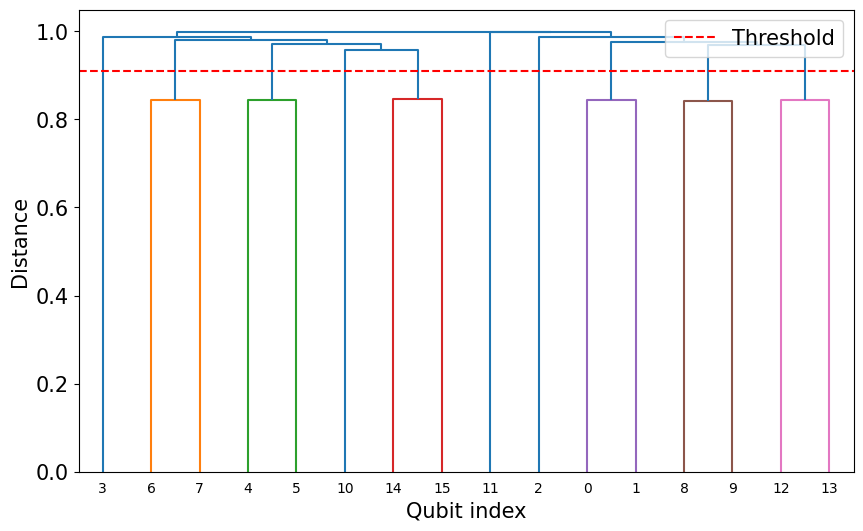

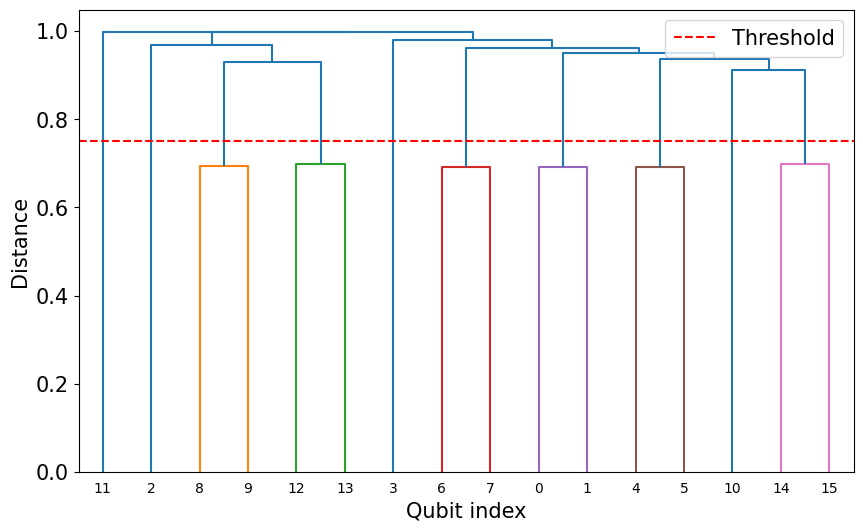

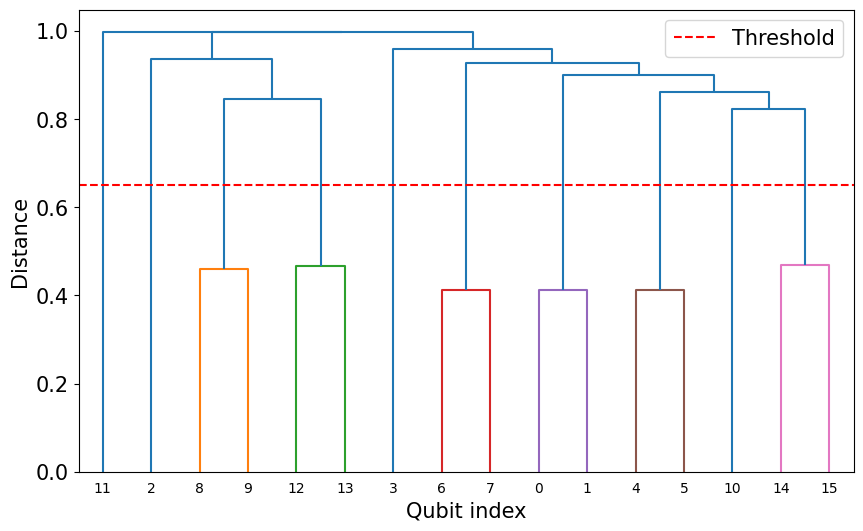

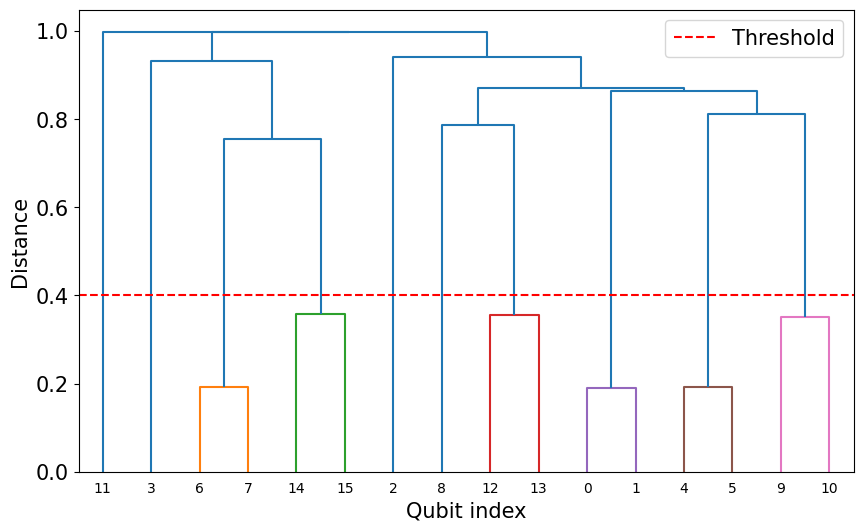

In [68]:

# Plotting dendrograms
update_cutoffs = [ 0.91, 0.75, 0.65, 0.4]
for dict in dict_array:
    for rot_dict, cutoff in zip(dict, update_cutoffs):
        Z = rot_dict['Z']
        #print(rot_dict["noise_cluster_labels"])
        #print(rot_dict['two_point_corr_labels'])
        #print(rot_dict[''])
        #cutoff = k_dict['dendrogram_cutoff']
        vis.plot_dendrogram(Z,save_path=f'{perm_data_path}', cutoff = cutoff)
        #k_dict['noise_cluster_labels'] = cl.compute_noise_cluster_labels(k_dict['Z'], k_dict['dendrogram_cutoff'])

# 100 qubit example

['No QREM ', 'Two-point QREM', 'Correlated QREM']
[ 8 27  0 48 43 25 11 41 15 31 18 47 20 28  4 39 17 13 29 23 37 38 12 26
 34 35 33 45  2 32 16 36  5 21 19 10 49 22  7 42 40  9  6 44 30 24  3  1
 14 46]


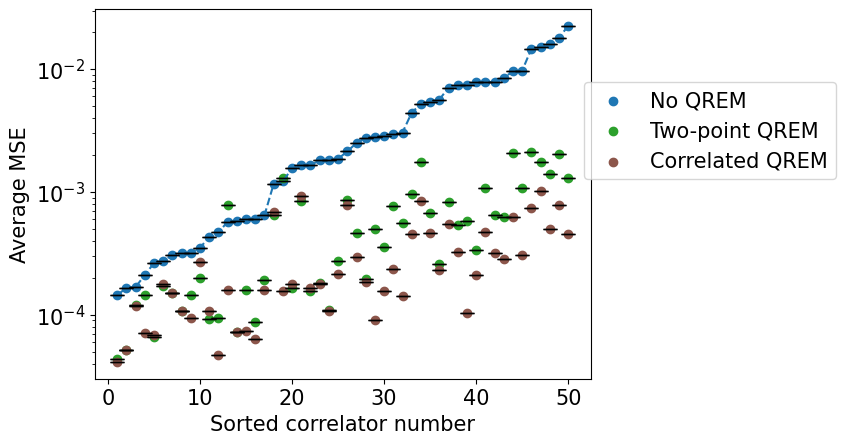

In [33]:
perm_data_path = 'QDOT_results/100_qubit_example/2025-02-28_17-37-26_d0873758-7f24-4469-8edc-c96f24288780'

file_list = glob.glob(f'{perm_data_path}/**/*.pkl', recursive=True)
dict_array = []
for file in file_list:
    with open(file, 'rb') as f:
        dict_array.append(pickle.load(f))
    

#perfect_clustering_dict = dict_array[1]
n_averages = dict_array[0]['n_averages']
two_point_corr_labels   = dict_array[0]['two_point_corr_labels']
traced_down_rho_true_array = dict_array[0]['traced_down_rho_true_array']

#standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict)
#perfect_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict)


n_op = 100
op_string_array = ot.generate_random_pauli_string(n_op,2)
true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]

#inf_array = []
state_array = []
MSE_array = []
for dict in dict_array:
    state, label_array = ot.load_state_array_from_result_dict(dict)
    print(label_array)
    
    # The states has shapes [n_modes, n_averages, len(two_point_corr_labels), 2**n_qubits, 2**n_qubits]
    #inf_array.append(ot.compute_mode_mean_infidelitites(state, traced_down_rho_true_array))#[filter_array]
    state_array.append(state)
    exp_value = ot.compute_state_array_exp_values(state,op_string_array)
    MSE_array.append(ot.compute_op_and_n_averages_mean_MSE(exp_value, true_exp_value))
    # Resulting arrays have shapes [std_averages,n_modes,n_correlators]

mean_MSE_array = np.mean(MSE_array, axis=0)

sorting_arg = np.argsort(mean_MSE_array.T[:,0])
print(sorting_arg)
sorted_MSE = mean_MSE_array.T[sorting_arg]
#perfect_sorted_MSE = perfect_clustering_MSE.T[sorting_arg]
colors = ['C0', 'C2', 'C5']
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(sorted_MSE[:,0]))+1,sorted_MSE[:,0],linestyle='dashed' )
for i in range(len(sorted_MSE[0])):
    ax.scatter(np.arange(len(sorted_MSE[:,i]))+1, sorted_MSE[:,i],label = label_array[i], color = colors[i], marker='o')
    ax.errorbar(np.arange(len(sorted_MSE[:,i]))+1, sorted_MSE[:,i], yerr=np.std(MSE_array, axis=0).T[sorting_arg][:,i], fmt='none', ecolor='k', capsize=5)
#ax.scatter(np.arange(len(sorted_MSE[:,0])), perfect_sorted_MSE[:,2],label = 'Perfect clustering', marker='x')
# MSE of shape [n_method , n_correlators]
# for i in range(len(label_array)):
#     ax.bar(i, standard_mean_MSE[i], label=label_array[i])
#     ax.plot(i, perfect_clustering_MSE[i], "kx")
ax.set_yscale('log')
ax.set_ylabel(f'Average MSE')
ax.set_xlabel('Sorted correlator number')
fig.legend(bbox_to_anchor=(1.3,0.75))
corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]



